In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
#import fitsio 
#from astropy.io import fits
#from astropy.table import Table
import desispec.io
%matplotlib inline


### The purpose of this notebook is to test the reproducibility of quasar spectra simulated using desisim quickquasars when adding different features such as DLAs, BALs, and metals. 

In [2]:
##These lines are only needed if one is using local branch.
#Make sure that the branch you want to use is active in your local directory in cori if your using this notebook in jupyer-dev.nersc.. 
#To use de master branch of all codes from jupyter-dev.nersc, just mark down this cell. 

os.environ['PYTHONPATH']='/global/homes/a/alxogm/desi/code/desisim/py:'+os.environ['PYTHONPATH']
os.environ['PATH']='/global/homes/a/alxogm/desi/code/desisim/bin/:'+os.environ['PATH']


### Lets define some plotting functions, that will be useful along the notebook. 

In [3]:
#A simple filter was added to retain some of the noise and check this is reproduced, but still be able to spot differences due to features by eye. Plotspec routine was taken from someother tutorial. It allows to add the true spectra although we will not use this option here 
#Thes plots will show the three arms of the spectrograph in colors blue ['b'], red ['r'] and yellow ['z'].

from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=11,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
        
    plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return
    
#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This is only to compute the observed wavelenght of given line that corresponds to the quasar redshift. e.g 

def draw_obsline(lbda,z):
    return (1.+z)*lbda




### Now, lets define the base parameters of our simulations. As well as the paths to where the transmission file will be read. One of the important things is to define a seed that will be used in all the spectra simulations. 

#### If you want to run a full simulation it is best you do it using the slurmscript https://github.com/desihub/desisim/blob/master/etc/quickquasar_slurm_script.sh

In [4]:
exptime=4000   #Exposure time
#ifile='/project/projectdirs/desi/mocks/lya_forest/london/v2.0/0/0/transmission-16-0.fits'        #Transmission file to read, v3 cointains metals, most of the notebook works also with v2.0, except the part corresponding to the metal addition from transrmision file. 
ifile=specfile='/project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits'   #Choose one pixel to simulate the quasars. 
outdir='/project/projectdirs/desi/users/alxogm/desi/mocks/london/v1.1/'  #Where do you want to save the files, although in this particular notebook we will be overwritring the files. 
zmin=1.8
nmax=20   #máximum number of spectra to simulate in a pixel .
seed=123  #Seed to ensure reproducibility. 

### First we run quickquasars twice.One with an exposure time of 4000 (four passes) and another run with exptime=1e8, this last will call it the no-noise.

In [5]:
#By default we will be continusly overwritting this file in this notebook.
#If you really want to save the files please indicate a diffrent filename each time you run a cell like this one. 

specfile=outdir+'spectra.fits'  
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile} --zmin {zmin} --zbest --mags --desi-footprint --overwrite \
--nmax {nmax} --seed {seed}'.format(exptime=exptime,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!time $cmd
spectra_base= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:324:simulate_one_healpix: Increase wavelength range from 3550:6499 to 3329:6499 to compute magnitudes
INFO:quickquasars.py:3

In [6]:
###RUN with specsim/simulator.py modified  
##Not exactly the same spectra due to the modifcations to specsim, but they match if this lines are run with the same specsim
specfile=outdir+'spectra.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --mags --desi-footprint --overwrite --nmax {nmax} --seed {seed}'.format(exptime=1e8,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!time $cmd
spectra_base_nonoise= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:324:simulate_one_healpix: Increase wavelength range from 3550:6499 to 3329:6499 to compute magnitudes
INFO:quickquasars.py:3

### Lets make a first plot, comparing the noise and no noise base spectra. 

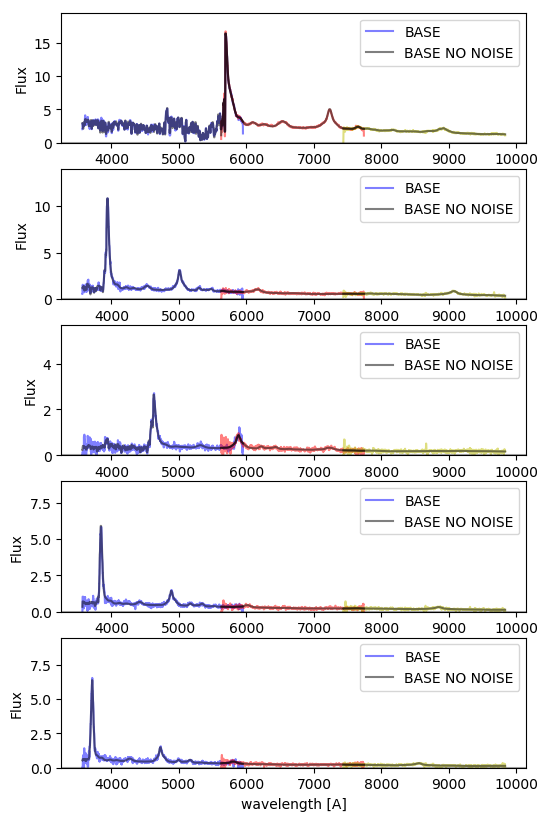

In [7]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base, i,label='BASE')
    plotspec(spectra_base_nonoise, i,color=['k','k','k'],label='BASE NO NOISE')



## Now we run a case adding DLAs randomly but without noise and compare to no DLA with no noise. 
## For this we set the exposure time to a large number. It can also be checked by commenting out  the add_noise in quickspectra


In [8]:
specfile=outdir+'spectra_dla_ran_-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} --zbest \
    --mags --desi-footprint --overwrite --nmax {nmax} --seed {seed} --dla random '.format(exptime=1e8,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!$cmd
spectra_dla_random_nonoise= desispec.io.read_spectra(specfile)


INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:259:simulate_one_healpix: Adding DLAs randomly
INFO:quickquasars.py:304:simulate_one_healpix: Added 1 DLAs
INFO:quickquasars

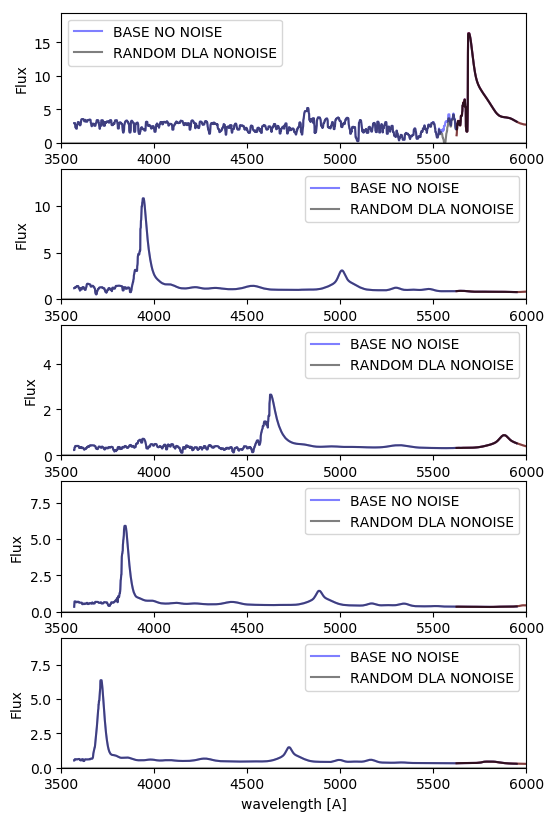

In [12]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base_nonoise, i,label='BASE NO NOISE')

    plotspec(spectra_dla_random_nonoise, i,color=['k','k','k'],label='RANDOM DLA NONOISE')
    plt.xlim(3500,6000)


## Here we plot the ratio of spectra  DLA and NO-DLAs, to check that only difference is where the DLAs had been injected

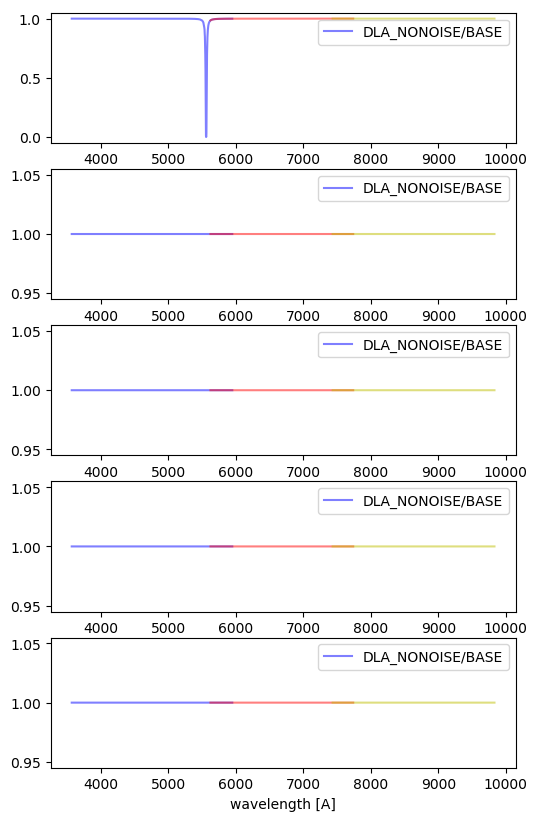

In [16]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_ratio(spectra_dla_random_nonoise,spectra_base_nonoise,i,label='DLA_NONOISE/BASE')


## Now run a case random DLAs case with noise

In [17]:
specfile=outdir+'spectra_dla_ran_-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} --zbest --mags --desi-footprint --overwrite --nmax {nmax} \
--seed {seed} --dla random '.format(exptime=exptime,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!$cmd
spectra_dla_random= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:259:simulate_one_healpix: Adding DLAs randomly
INFO:quickquasars.py:304:simulate_one_healpix: Added 1 DLAs
INFO:quickquasars

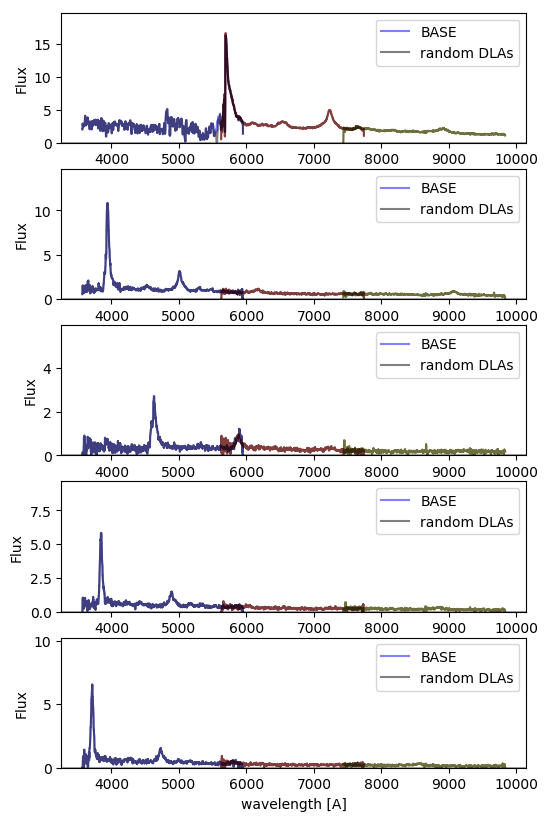

In [19]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base, i,label='BASE')
    plotspec(spectra_dla_random, i,color=['k','k','k'],label='random DLAs')



## Now we plot the difference between the two previous sets of spectra and note the only difference is the DLA.  We plot here the diffirence to avoid spurious differences due to noise at zero level. 

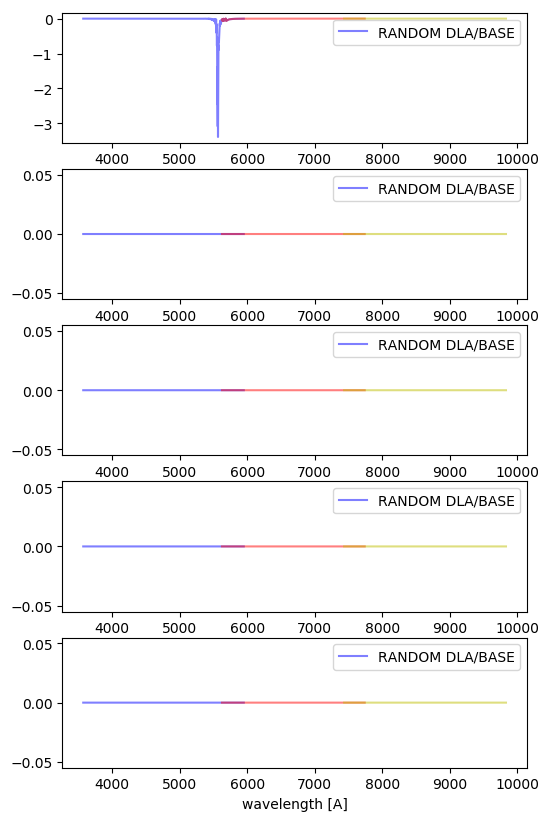

In [22]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_diff(spectra_dla_random,spectra_base,i,label='RANDOM DLA/BASE')



# Now lets add the  DLAs according to the transmision file, and compare with the base set of spectra.

In [23]:
specfile=outdir+'spectra_dla_file-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} --zbest --mags --desi-footprint --overwrite --nmax {nmax} \
--seed {seed} --dla file '.format(exptime=exptime,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!$cmd
spectra_dla_file= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:262:simulate_one_healpix: Adding DLAs from transmission file
INFO:quickquasars.py:304:simulate_one_healpix: Added 3 DLAs
INF

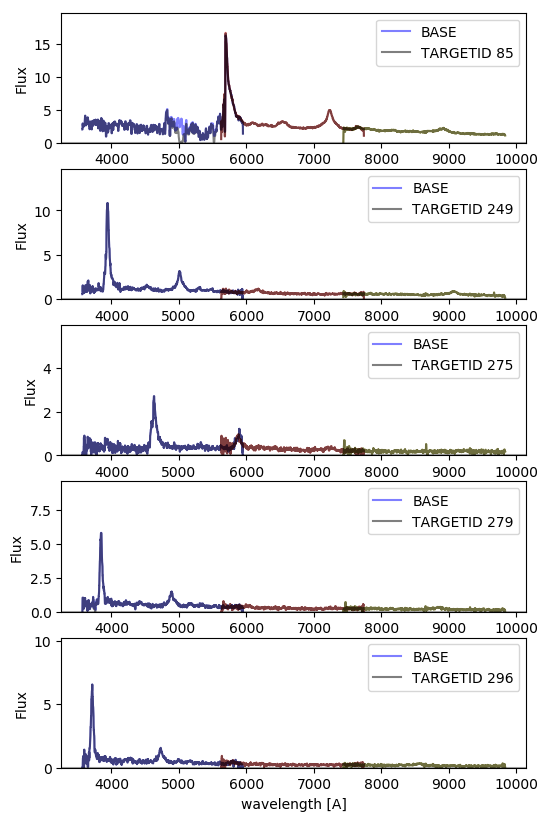

In [24]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base, i,label='BASE')
    plotspec(spectra_dla_file,i,color=['k','k','k'],label='TARGETID {}'.format(spectra_dla_file.fibermap['TARGETID'][i]))



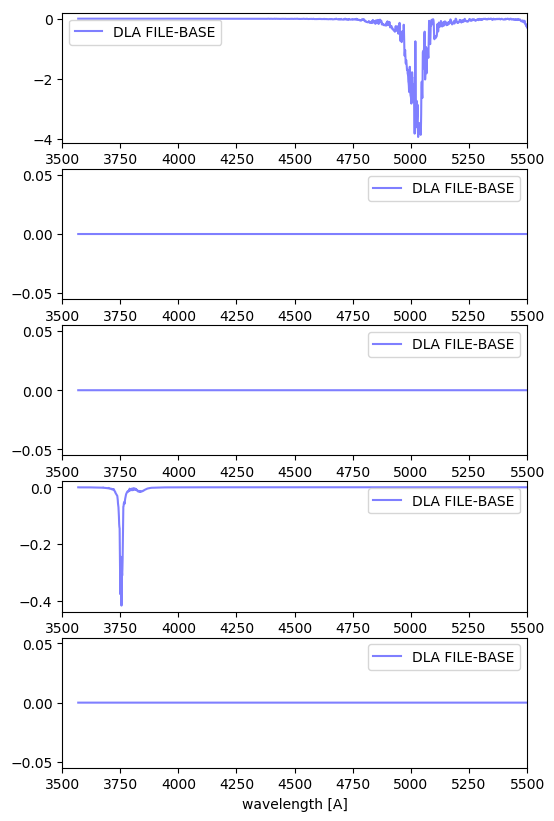

In [27]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_diff(spectra_dla_file,spectra_base,i,label='DLA FILE-BASE')
    plt.xlim(3500,5500)

# So we have checked the reproducibility of spectra in presence of DLAs. Lets look at adding BALs

In [28]:
specfile=outdir+'spectra-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} --zbest --mags --desi-footprint --overwrite \
--nmax {nmax} --seed {seed} --bal 0.2 '.format(exptime=exptime,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)  
!$cmd
spectra_bal= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
INFO:io.py:895:read_basis_templates: Reading /global/project/projectdirs/desi/spectro/templates/basis_templates/v2.6/bal_templates_v2.0.fits
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO

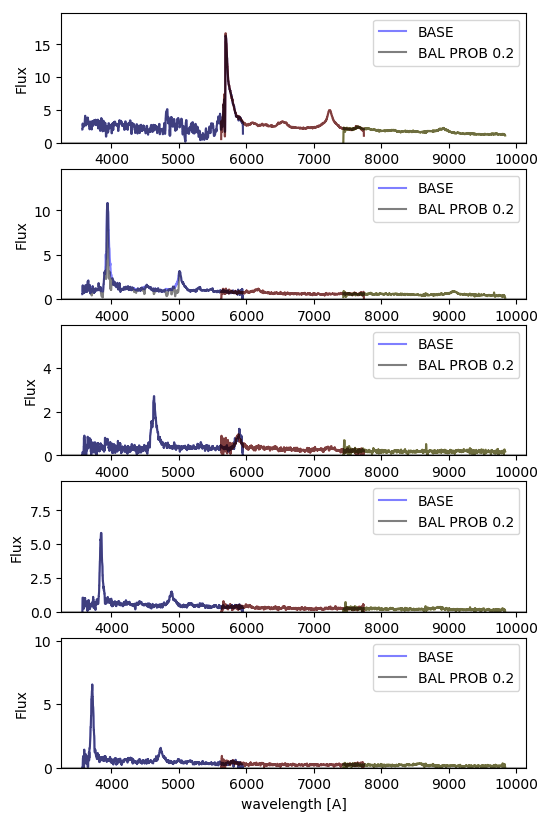

In [30]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base,i,label='BASE')
    plotspec(spectra_bal, i,color=['k','k','k'],label='BAL PROB 0.2')




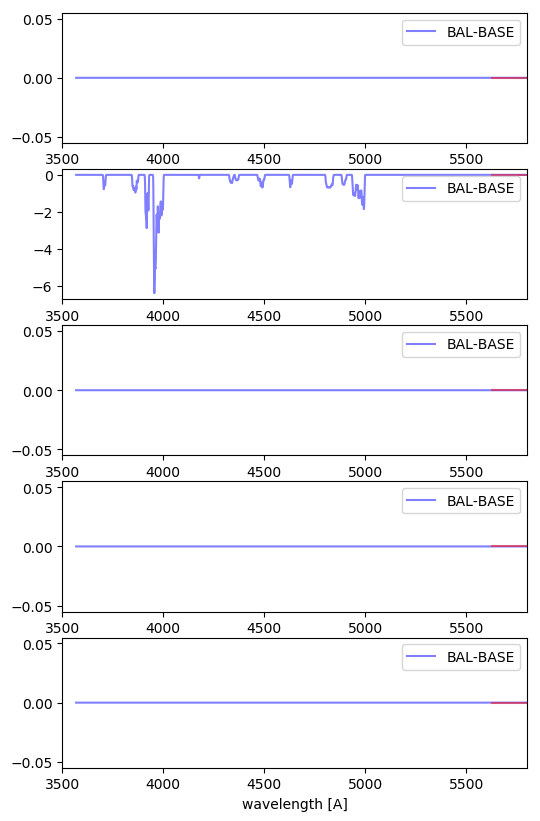

In [32]:
plt.figure(figsize=(6,10),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_diff(spectra_bal,spectra_base,i,label='BAL-BASE')
    plt.xlim(3500,5800)

## NICE! BALs addition is also well reproduced. Finally lets test for the two implementations of metals. From desisim (--metals all) and from transmision file. We'll check this without noise first

In [34]:
specfile=outdir+'spectra-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin}\
    --zbest --mags --desi-footprint --overwrite --nmax {nmax} --seed {seed}\
    --metals-from-file'.format(exptime=1e8,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)

!$cmd
spectra_metals_file_nonoise= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:324:simulate_one_healpix: Increase wavelength range from 3550:6499 to 3329:6499 to compute magnitudes
INFO:quickquasars.py:3

In [42]:
specfile=outdir+'spectra-16-0.fits'
cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin}\
    --zbest --mags --desi-footprint --overwrite --nmax {nmax} --seed {seed}\
    --metals all '.format(exptime=1e8,ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)

!$cmd
spectra_metals_all_nonoise= desispec.io.read_spectra(specfile)

INFO:quickquasars.py:541:main: Load SIMQSO model
INFO:quickquasars.py:546:main: Load DeCAM and WISE filters for target selection sim.
ifilename /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:119:get_healpix_info: healpix=HPXPIXEL=8
INFO:quickquasars.py:124:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:132:get_healpix_info: hpxnest from HPXNEST = True
found 8 16 True
INFO:quickquasars.py:206:simulate_one_healpix: Read skewers in /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits, random seed = 1164498
INFO:quickquasars.py:210:simulate_one_healpix: Read transmission file /project/projectdirs/desi/mocks/lya_forest/london/test-v3.0/0/8/transmission-16-8.fits
INFO:quickquasars.py:219:simulate_one_healpix: Select QSOs in DESI footprint 5 -> 5
INFO:quickquasars.py:324:simulate_one_healpix: Increase wavelength range from 3550:6499 to 3329:6499 to compute magnitudes
INFO:quickquasars.py:3

## Before plotting the spectra lets read some information from the transmision files, as the redshift of the quasars so that we can know more or least where the metals lines should appear. 

In [36]:
##Reading transmission file
import fitsio
hdu=fitsio.FITS(ifile)
wave=hdu['WAVELENGTH'].read()
transmission=hdu['TRANSMISSION'].read()
meta=hdu['METADATA'].read()
IDS=meta['MOCKID']

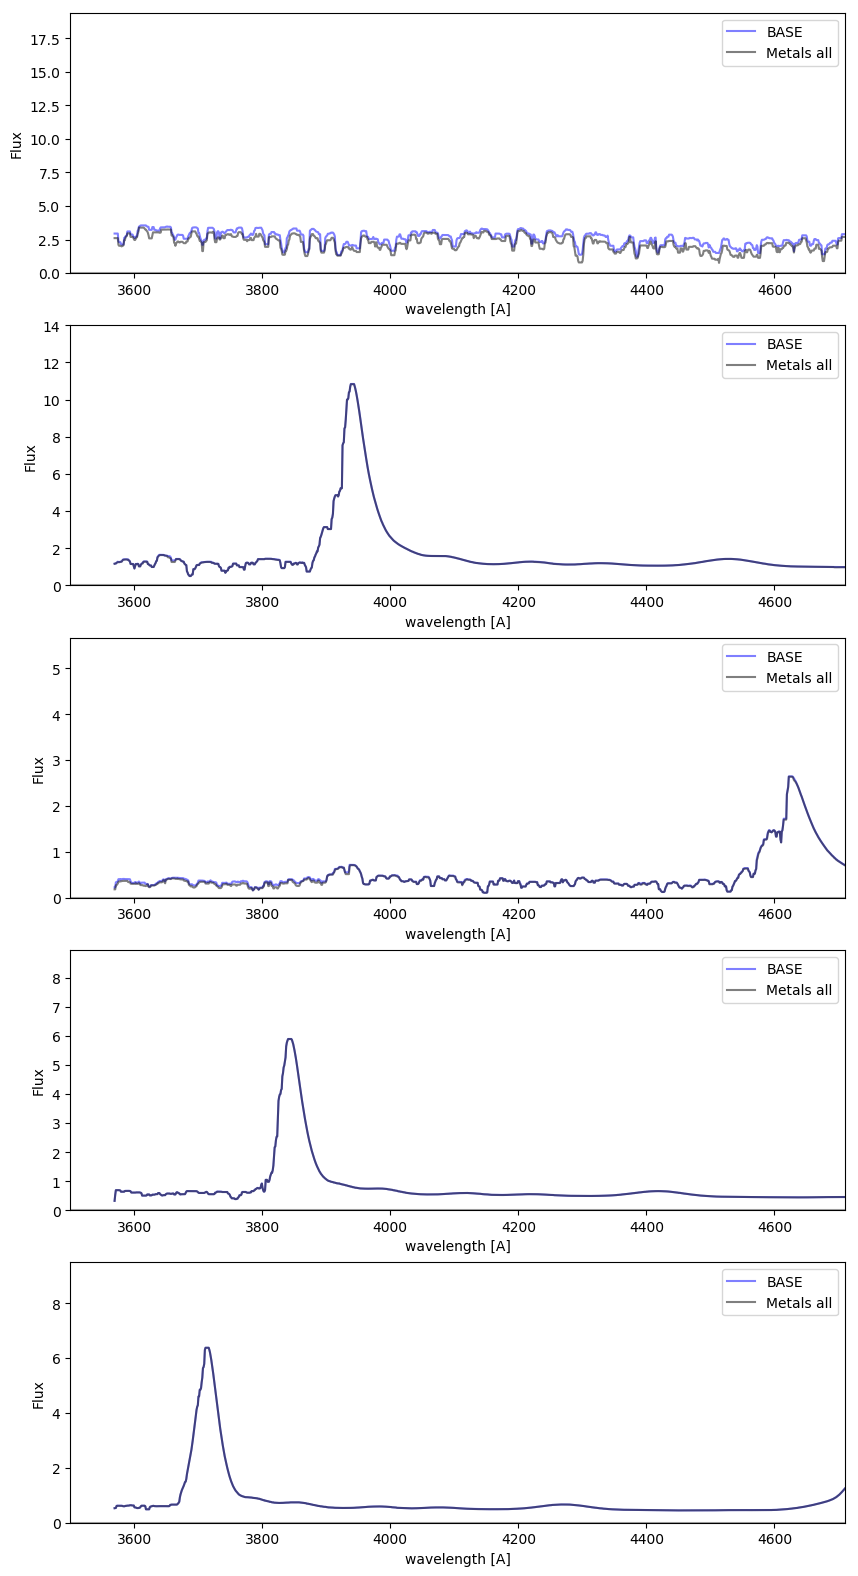

In [49]:
plt.figure(figsize=(10,20),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base_nonoise,i,label='BASE')
    plotspec(spectra_metals_all_nonoise, i,color=['k','k','k'],label='Metals all')
    z=meta[meta['MOCKID']==spectra_base.fibermap['TARGETID'][i]]['Z']
    plt.xlim(3500,lyaline+1000)
    #plt.ylim(0.2,1.5)

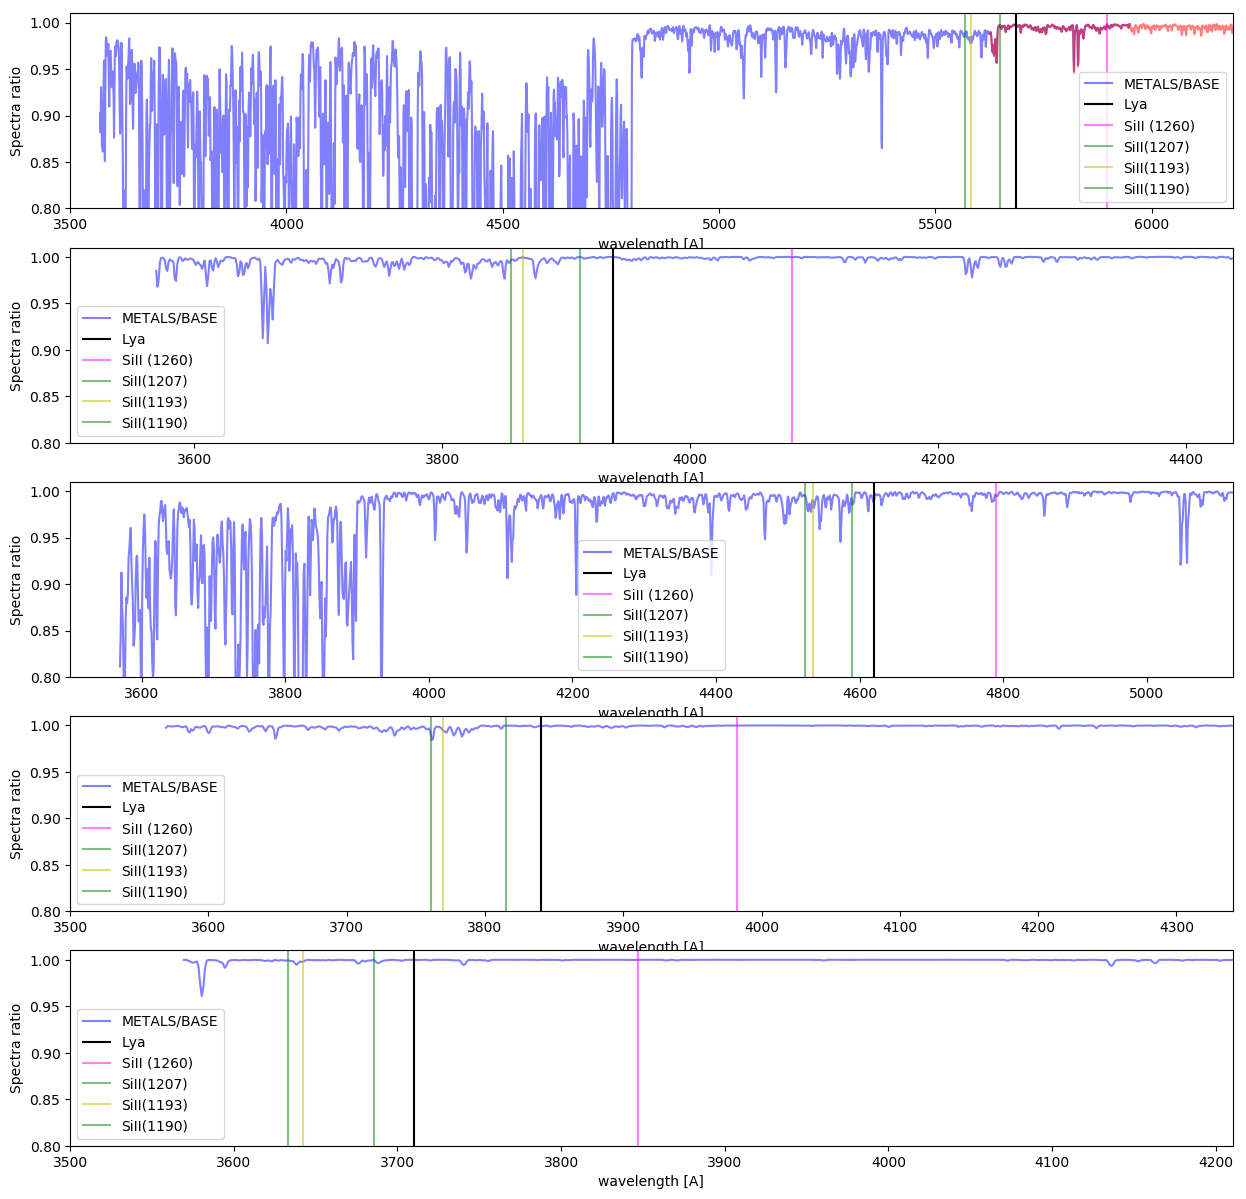

In [52]:
plt.figure(figsize=(15,15),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_ratio(spectra_metals_all_nonoise,spectra_base_nonoise,i,label='METALS/BASE')
    z=meta[meta['MOCKID']==spectra_base_nonoise.fibermap['TARGETID'][i]]['Z']
    lyaline=draw_obsline(1215.67,z)
    plt.axvline(lyaline,color='k',label='Lya')
    plt.axvline(draw_obsline(1260.42,z),color='magenta',alpha=0.5,label='SiII (1260)')
    plt.axvline(draw_obsline(1207.50,z),alpha=0.5,color='g',label='SiII(1207)')
    plt.axvline(draw_obsline(1193.29,z),color='y',alpha=0.5,label='SiII(1193)')
    plt.axvline(draw_obsline(1190.42,z),color='green',alpha=0.5,label='SiII(1190)')
    plt.ylabel('Spectra ratio')

    plt.legend()
    plt.xlim(3500,lyaline+500)
    plt.ylim(0.8,1.01)




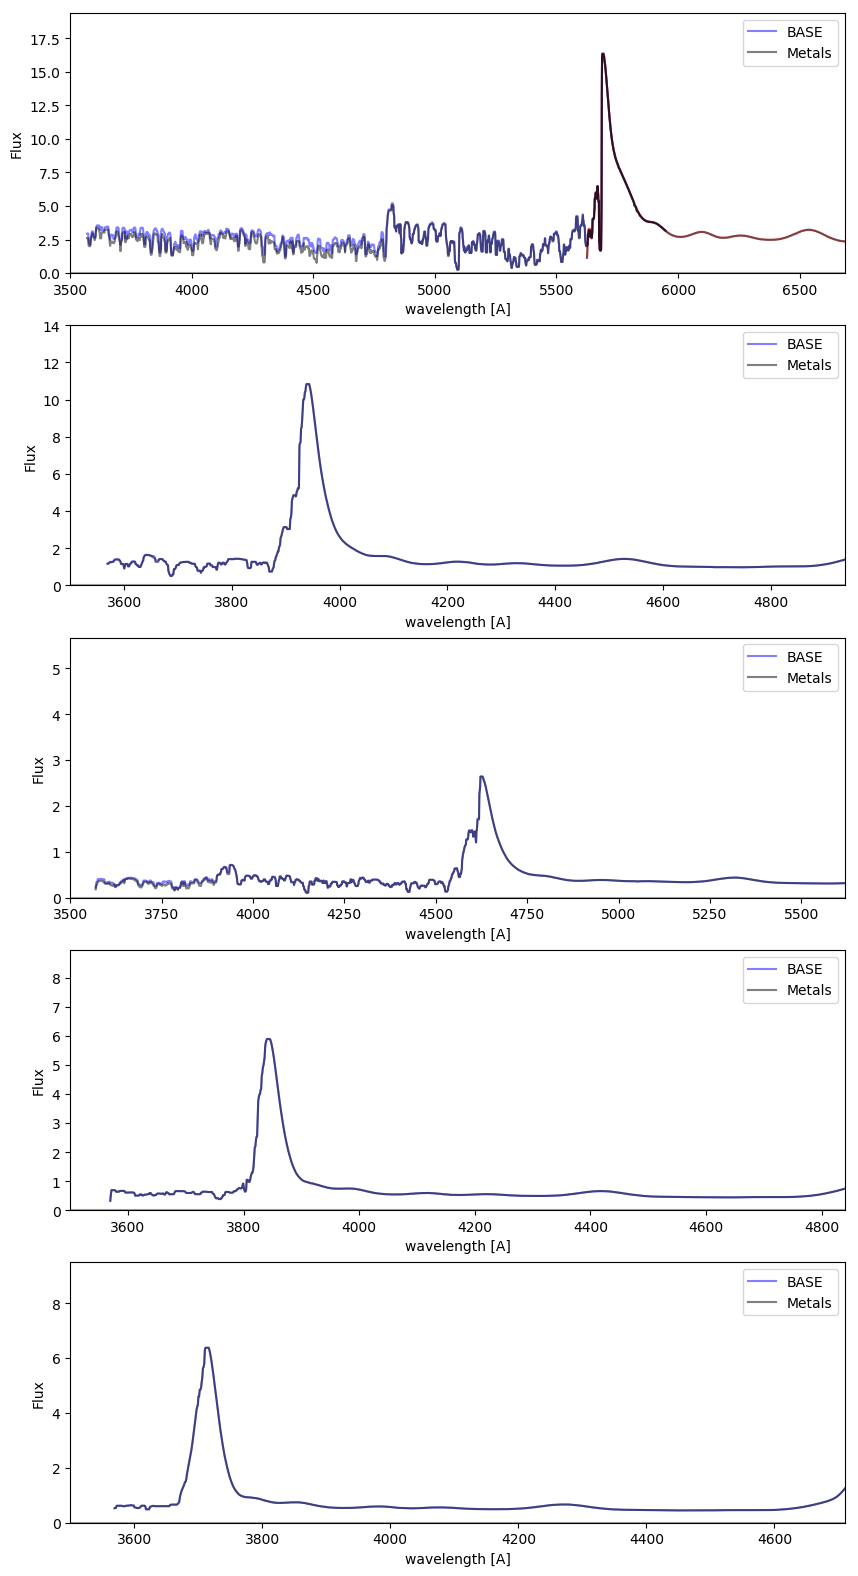

In [54]:
plt.figure(figsize=(10,20),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec(spectra_base_nonoise,i,label='BASE')
    plotspec(spectra_metals_all_nonoise, i,color=['k','k','k'],label='Metals')
    z=meta[meta['MOCKID']==spectra_base_nonoise.fibermap['TARGETID'][i]]['Z']
    lyaline=draw_obsline(1215.67,z)
    plt.xlim(3500,lyaline+1000)
    #plt.ylim(0.2,1.5)

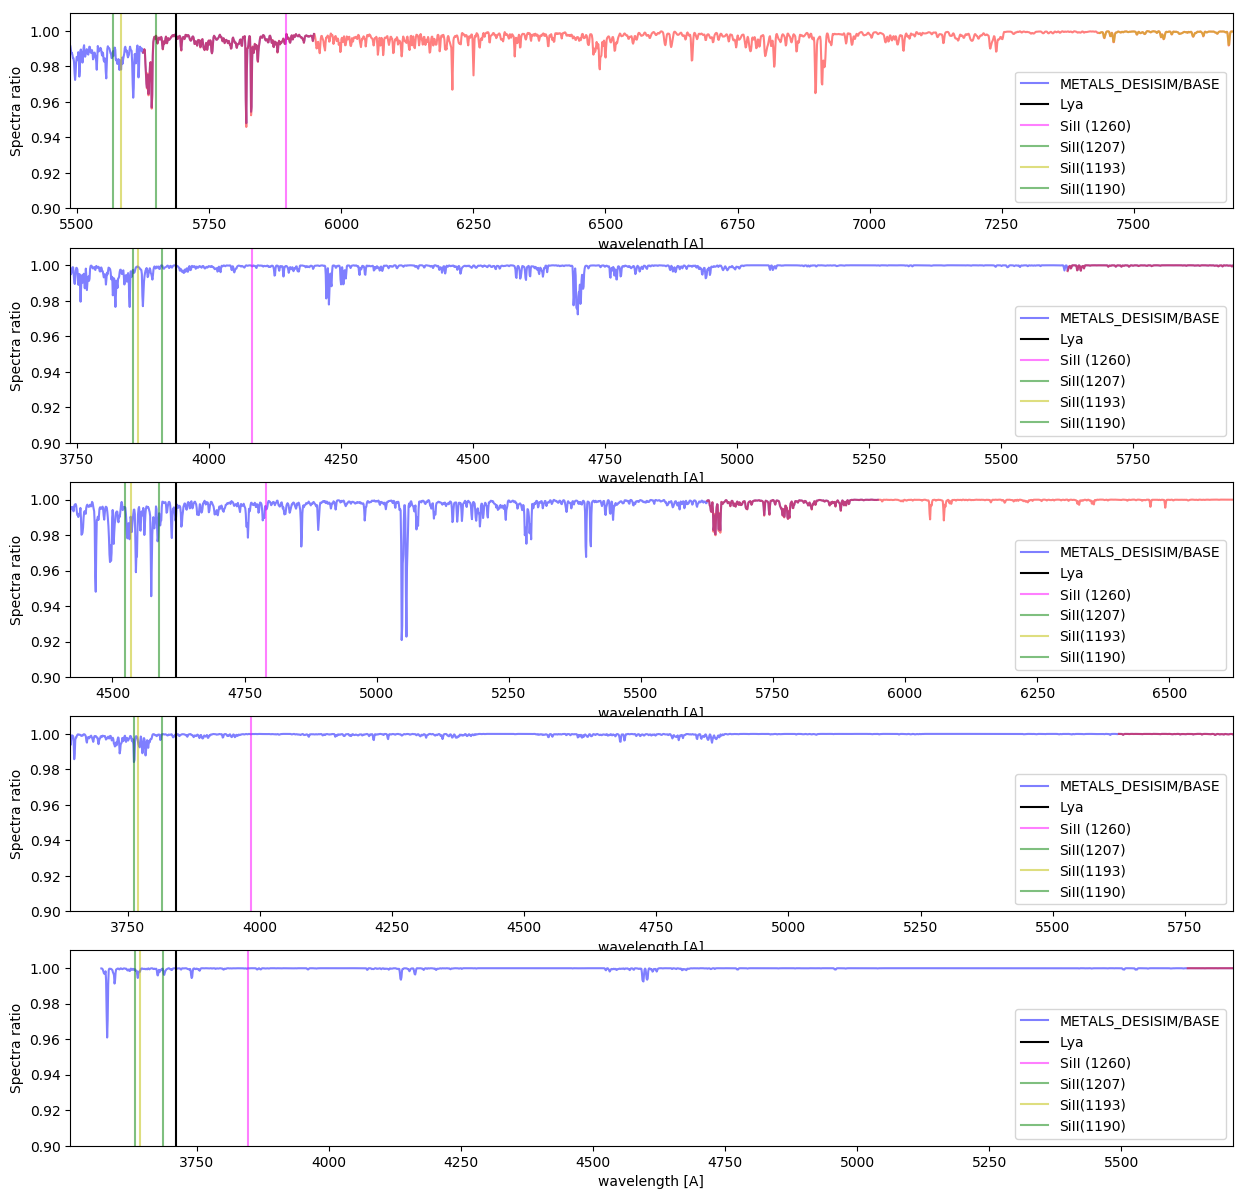

In [56]:
plt.figure(figsize=(15,15),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_ratio(spectra_metals_all_nonoise,spectra_base_nonoise,i,label='METALS_DESISIM/BASE')
    z=meta[meta['MOCKID']==spectra_base_nonoise.fibermap['TARGETID'][i]]['Z']
    lyaline=draw_obsline(1215.67,z)
    plt.axvline(lyaline,color='k',label='Lya')
    plt.axvline(draw_obsline(1260.42,z),color='magenta',alpha=0.5,label='SiII (1260)')
    plt.axvline(draw_obsline(1207.50,z),alpha=0.5,color='g',label='SiII(1207)')
    plt.axvline(draw_obsline(1193.29,z),color='y',alpha=0.5,label='SiII(1193)')
    plt.axvline(draw_obsline(1190.42,z),color='green',alpha=0.5,label='SiII(1190)')
    plt.ylabel('Spectra ratio')

    plt.legend()
    plt.xlim(lyaline-200,lyaline+2000)
    plt.ylim(0.9,1.01)





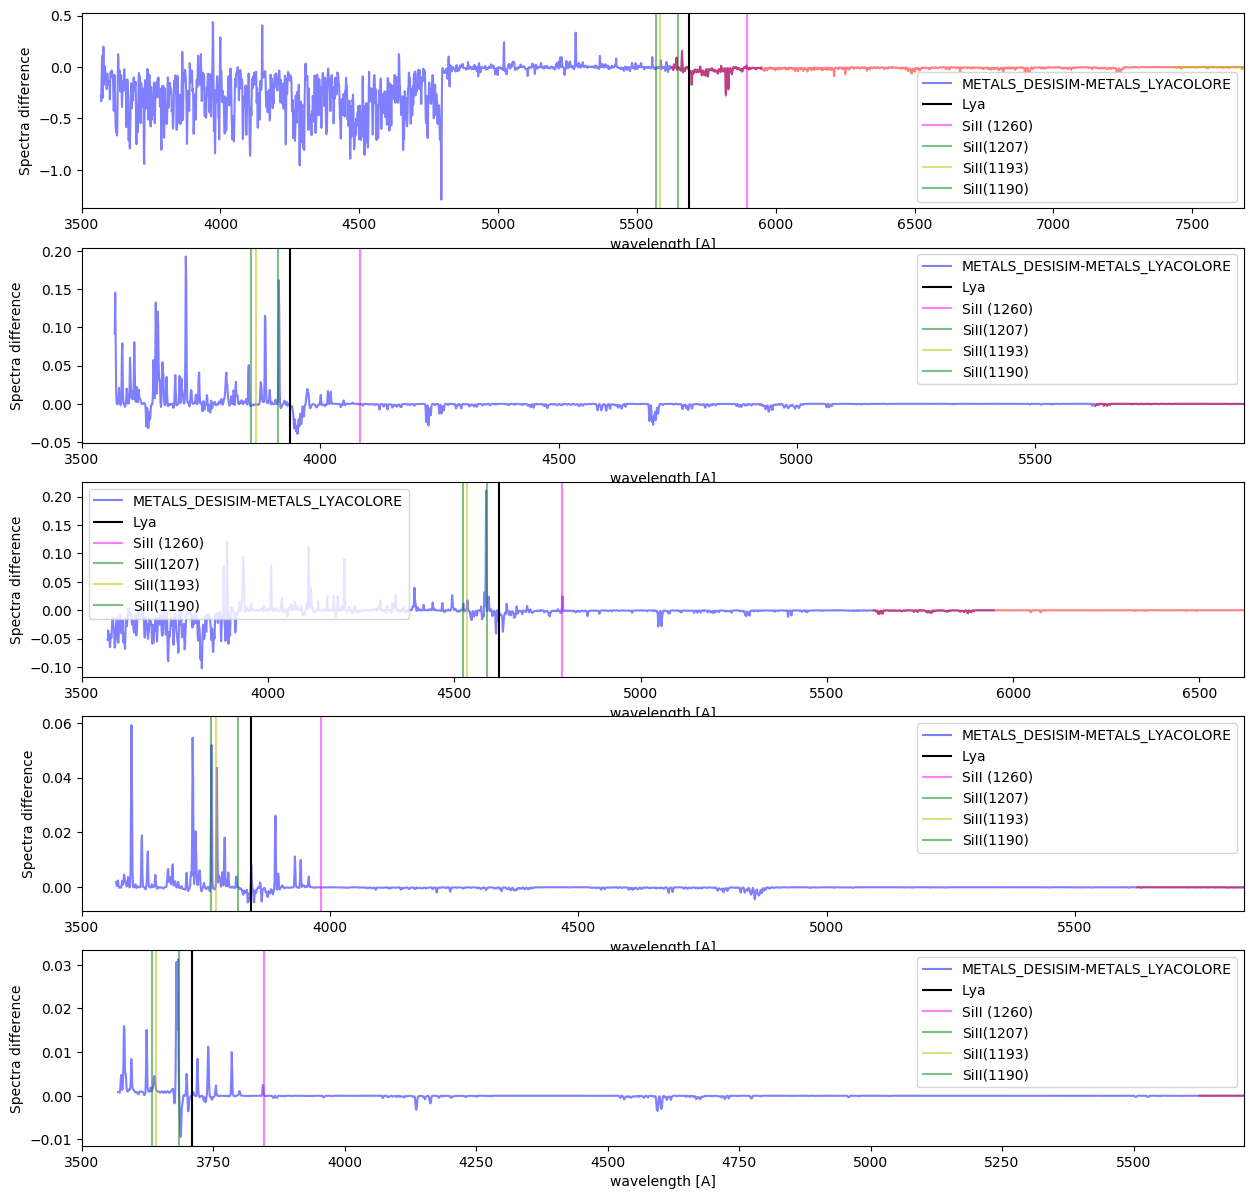

In [59]:
plt.figure(figsize=(15,15),dpi=100)
for i in range(5):
    plt.subplot(5,1,i+1)
    plotspec_diff(spectra_metals_all_nonoise,spectra_metals_file_nonoise,i,label='METALS_DESISIM-METALS_LYACOLORE')
    z=meta[meta['MOCKID']==spectra_base_nonoise.fibermap['TARGETID'][i]]['Z']
    lyaline=draw_obsline(1215.67,z)
    plt.axvline(lyaline,color='k',label='Lya')
    plt.axvline(draw_obsline(1260.42,z),color='magenta',alpha=0.5,label='SiII (1260)')
    plt.axvline(draw_obsline(1207.50,z),alpha=0.5,color='g',label='SiII(1207)')
    plt.axvline(draw_obsline(1193.29,z),color='y',alpha=0.5,label='SiII(1193)')
    plt.axvline(draw_obsline(1190.42,z),color='green',alpha=0.5,label='SiII(1190)')
    plt.ylabel('Spectra difference')

    plt.legend()
    plt.xlim(3500,lyaline+2000)




